# IMPORT

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import display
from IPython.display import HTML

### MULTI-STREAM ###
path_multistream = "C:/Users/dani/inference/multistream/inference_results.csv"
df_multistream = pd.read_csv(path_multistream)

### STREAM-BASED ### 

# Load the data
path_stream = "C:/Users/dani/inference/WALT-journal/inference_results.csv"
df_stream = pd.read_csv(path_stream)
# Convert source_domain and source_period into a tuple for easy comparison
df_stream['source_combo'] = list(zip(df_stream['source_domain'], df_stream['source_period']))

### POOL-BASED ### 

# Load the data
path_poolbased = "C:/Users/dani/inference/WALT-poolbased/inference_results.csv"
df_poolbased = pd.read_csv(path_poolbased)
# Convert source_domain and source_period into a tuple for easy comparison
df_poolbased['source_combo'] = list(zip(df_poolbased['source_domain'], df_poolbased['source_period']))

### FORMATTING OPTIONS
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# UTILS


In [77]:
def benchmark_strategies_plot(strategies_df,
                              baseline_df=None,
                              random_df=None,
                              prefix_random=None):
    # Group by strategy and sample and calculate average 'mAP50-95'
    grouped_df = strategies_df.groupby(['strategy', 'samples']).mean(numeric_only=True)['mAP50-95'].reset_index()

    # Pivot to wide format for plotting
    pivot_df = grouped_df.pivot(index='samples', columns='strategy', values='mAP50-95')
    
    # Plot
    plt.figure(figsize=(8, 6))
    ax = plt.gca()  # get the current axes, creating them if necessary
    for column in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[column], marker='', linewidth=2, label=column)
    
    if baseline_df is not None:
        # Calculate average 'mAP50-95' for each strategy
        baseline_df_avg = baseline_df.groupby('strategy').mean(numeric_only=True)['mAP50-95']
        # For each model, add a horizontal line across the entire x-axis range
        for strategy, avg_mAP in baseline_df_avg.items():
            ax.hlines(avg_mAP, xmin=pivot_df.index.min(), xmax=pivot_df.index.max(), colors='black', linestyles='dotted', alpha=1, linewidth=2)
            # annotate the lines
            plt.text(pivot_df.index.max(), avg_mAP, f"{strategy}: {avg_mAP:.2f}", color='blue', va='center', ha='left')

    # Add average and variance for 'uniform-random' strategies
    if random_df is not None:
        random_grouped = random_df.groupby('samples')['mAP50-95'].agg(['mean', 'std'])
        ax.plot(random_grouped.index, random_grouped['mean'], label=prefix_random, color='red')
        ax.fill_between(random_grouped.index, 
                        random_grouped['mean'] - random_grouped['std'], 
                        random_grouped['mean'] + random_grouped['std'], 
                        color='red', alpha=0.1, label='1 Std Dev random')

    # Set labels, legend, and title
    ax.legend()
    ax.set_title('Average mAP50-95 values per sample for different strategies')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Average mAP50-95')
    ax.grid(True)

    plt.show()



In [86]:
def filter_df(df, same_domain = False, strategies = None, 
              samples=None, source_periods=None, source_domains=None, 
              excluded_domains=None, dom_periods = None, target_domain=None, students=None):        
    
    filtered_df = df
    
    if strategies is not None:
        filtered_df = filtered_df[filtered_df['strategy'].isin(strategies)]
        
    if samples is not None: 
        filtered_df = filtered_df[filtered_df['samples'].isin(samples)]
        
    if same_domain:
        filtered_df = filtered_df[filtered_df['source_domain'] == filtered_df['target_domain']]
    
    if source_periods is not None:
        filtered_df = filtered_df[filtered_df['source_period'].isin(source_periods)]
    
    if source_domains is not None:
        filtered_df = filtered_df[filtered_df['source_domain'].isin(source_domains)]
    
    if excluded_domains is not None:
        filtered_df = filtered_df[~filtered_df['target_domain'].isin(excluded_domains)]
        
    if dom_periods is not None:
        filtered_df = filtered_df[filtered_df['source_combo'].isin(restricted_dom_periods)]
        
    if target_domain is not None:
        filtered_df = filtered_df[filtered_df['target_domain'].isin(target_domain)]
        
    if students is not None:
        filtered_df = filtered_df[filtered_df['student'].isin(students)]
    
    return filtered_df, filtered_df['mAP50-95'].mean(), filtered_df['mAP50-95'].std()


def getMAP5095stats(df, strategy, source_domain, source_period, sample, target_domain=None):
    filter = (df['strategy'] == strategy) & \
             (df['source_domain'] == source_domain) & \
             (df['source_period'] == source_period) & \
             (df['samples'] == sample)
    
    if target_domain is not None:
        filter = filter & (df['target_domain'] == target_domain)

    mean = df[filter]['mAP50-95'].mean()
    mean = df[filter]['mAP50-95'].std()
    return mean

In [79]:
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def perform_statistical_tests(df1, df2, df1_name, df2_name, suffix=''):
    if suffix:
        suffix = f'_{suffix}'
    
    if len(df1) < 3 or len(df2) < 3 or len(df1['mAP50-95']) == 0 or len(df2['mAP50-95']) == 0:
        return {
            f't-statistic{suffix}': None,
            f'p-value{suffix}': None,
            f'T-test result{suffix}': "Not testable",
            f'shapiro-wilk {df1_name}{suffix}': None,
            f'shapiro-wilk {df1_name} result{suffix}': "Not testable",
            f'shapiro-wilk {df2_name}{suffix}': None,
            f'shapiro-wilk {df2_name} result{suffix}': "Not testable",
            f'levene{suffix}': None,
            f'levene result{suffix}': "Not testable",
            f'mann-whitney u{suffix}': None,
            f'mann-whitney u result{suffix}': "Not testable"
        }

    t_statistic, p_value_t = ttest_ind(df1['mAP50-95'], df2['mAP50-95'])
    t_test_result = 'Means statistically different (reject H0)' if p_value_t < 0.05 else 'Means statistically undifferent'
    
    _, p_shapiro_df1 = shapiro(df1['mAP50-95'])
    shapiro_df1_result = 'Sample does not look Gaussian (reject H0)' if p_shapiro_df1 < 0.05 else 'Sample looks Gaussian (fail to reject H0)'

    _, p_shapiro_df2 = shapiro(df2['mAP50-95'])
    shapiro_df2_result = 'Sample does not look Gaussian (reject H0)' if p_shapiro_df2 < 0.05 else 'Sample looks Gaussian (fail to reject H0)'

    _, p_levene = levene(df1['mAP50-95'], df2['mAP50-95'])
    levene_result = 'Variances do not look equal (reject H0)' if p_levene < 0.05 else 'Variances look equal (fail to reject H0)'

    _, p_mannwhitney = mannwhitneyu(df1['mAP50-95'], df2['mAP50-95'])
    mannwhitney_result = 'Different distribution (reject H0)' if p_mannwhitney < 0.05 else 'Same distribution (fail to reject H0)'

    data = {
        f't-statistic{suffix}': t_statistic, 
        f'p-value{suffix}': p_value_t,
        f'T-test result{suffix}': t_test_result,
        f'shapiro-wilk {df1_name}{suffix}': p_shapiro_df1,
        f'shapiro-wilk {df1_name} result{suffix}': shapiro_df1_result,
        f'shapiro-wilk {df2_name}{suffix}': p_shapiro_df2,
        f'shapiro-wilk {df2_name} result{suffix}': shapiro_df2_result,
        f'levene{suffix}': p_levene,
        f'levene result{suffix}': levene_result,
        f'mann-whitney u{suffix}': p_mannwhitney,
        f'mann-whitney u result{suffix}': mannwhitney_result
    }

    return data

def conduct_anova_and_tukey(dataframe_list, names, alpha=0.1):
    """
    Conducts ANOVA and Tukey HSD tests on multiple dataframes.
    
    Args:
    dataframe_list: list of pandas dataframes to be analyzed.
    names: a list of strings, specifying the names (or sources) of the dataframes.
    alpha: significance level for the Tukey HSD test.
    
    Returns:
    a tuple (anova_result, tukey_results)
    """
    
    # Error checking: make sure we have as many names as dataframes in the list
    if len(dataframe_list) != len(names):
        raise ValueError("The number of dataframes should match the number of names.")
    
    # Add source column and combine dataframes
    combined_list = []
    for df, name in zip(dataframe_list, names):
        df_copy = df.copy()
        df_copy['source'] = name
        combined_list.append(df_copy)
        
    combined_df = pd.concat(combined_list, ignore_index=True)
    
    # Rename mAP50-95 column for compatibility with patsy formula
    combined_df.rename(columns={'mAP50-95': 'mAP50_95'}, inplace=True)
    
    # Conduct ANOVA
    model = ols('mAP50_95 ~ source', data=combined_df).fit()
    anova_result = sm.stats.anova_lm(model, typ=2)
    
    # Create lists for the Tukey HSD test
    values = combined_df['mAP50_95'].tolist()
    labels = combined_df['source'].tolist()
    
    # Conduct Tukey HSD test
    tukey_results = pairwise_tukeyhsd(values, labels, alpha=alpha)
    
    return anova_result, tukey_results

The present work provides a comprehensive analysis of 

This work investigate the claim of the SBAD framework and aim to provide comprehensive analysis of
1. The scalability of the SBAD framework by completing the experiments on 9 cameras
2. Investigating the specialization claim. 
3. Quantifying the confirmation bias


The equation **sample big enough and diversity** remains the key for good fine-tuning. 

<h1> <font color="blue"> 1. SCALING SBAD EXPERIMENT TO 9 CAMERAS </font><h1>

The section validates the results obtained on the paper SBAD by running on 7 other cameras in addition totalling 9 cameras. The list is in annex. 

In this work we use 
1. The extensive set (comprises all the cameras and all their available weeks) 
2. Restricted dataset which involves only one week per camera and the first week.
    

In [80]:
# Create a list of domains and periods for which we want to filter
scal_dom_periods = [('cam1', 'week1'), ('cam1', 'week2'), ('cam1', 'week3'), ('cam1', 'week4'),
                    ('cam2', 'week1'), ('cam2', 'week2'), ('cam2', 'week3'), ('cam2', 'week4'),
                    ('cam3', 'week5'), 
                    ('cam4', 'week2'), ('cam4', 'week3'), 
                    ('cam5', 'week3'), 
                    ('cam6', 'week1'),('cam6', 'week3'),('cam6', 'week4'), 
                    ('cam7', 'week4'), 
                    ('cam8', 'week3'), 
                    ('cam9', 'week1')]

restricted_dom_periods  = [('cam1', 'week1'), 
                           ('cam2', 'week1'),
                           ('cam3', 'week5'), 
                           ('cam4', 'week2'),
                           ('cam5', 'week3'), 
                           ('cam6', 'week4'), 
                           ('cam7', 'week4'), 
                           ('cam8', 'week3'), 
                           ('cam9', 'week1')]

BASE_MODELS = ['yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x6']

 <h2> <font color="blue"> 1.1. ALL ELIGIBLE CAMERAS - WEEKS - SAMPLES </font><h2>

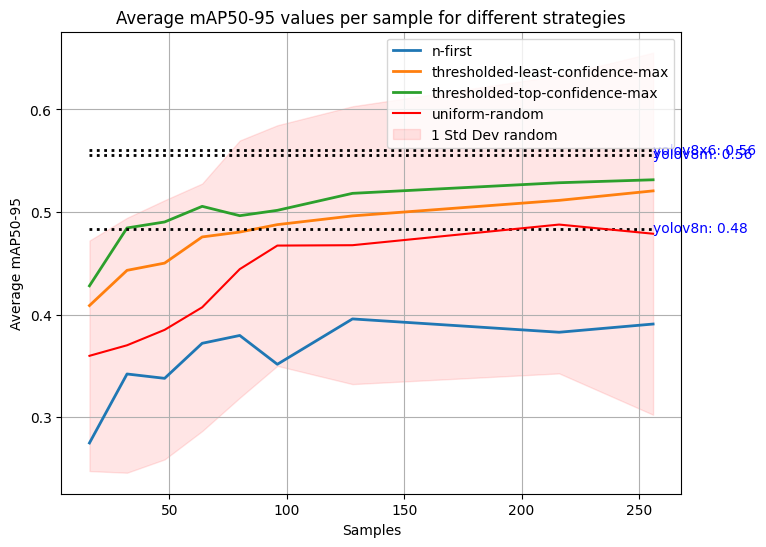

In [81]:
strategies_stream_based = ['n-first', 
                           'thresholded-top-confidence-max', 
                           'thresholded-least-confidence-max']
samples_stream_based = [16, 32, 48, 64, 80, 96, 128, 216, 256]

prefix_random_stream_based = 'uniform-random'
# Filter for a specific sample, strategy, and the domain-period combinations
strategies_df, a ,b  = filter_df(df_stream,
                              same_domain=True,
                              strategies=strategies_stream_based,
                              samples=samples_stream_based,
                              dom_periods=scal_dom_periods)

#Baseline
MODELS_TO_PLOT = ['yolov8n', 'yolov8m', 'yolov8x6']
baseline_df= df_stream[df_stream['strategy'].isin(MODELS_TO_PLOT)]

random_df,a,b = filter_df(df_stream, 
                      same_domain=True,
                      samples=samples_stream_based,
                      dom_periods=scal_dom_periods)

random_df = random_df[random_df['strategy'].str.startswith(prefix_random_stream_based)]



benchmark_strategies_plot(strategies_df,
                          baseline_df,
                          random_df,
                          prefix_random_stream_based)

The analysis shows that selecting the frames where the student is the most confident remains the best strategy and confirms SBAD results. 



 <h2> <font color="blue"> 1.2. Statistical analysis </font><h2>

In [54]:
sample = [256]
strategy1=['thresholded-top-confidence-max']
str1_short='top-conf'
strategy2=['thresholded-least-confidence-max']
str2_short='least-conf'
strategy3=['n-first']
str3_short='nfirst'


strat1_df, mean_strat1, std_strat1 = filter_df(df_stream,
                                               same_domain=True,
                                               strategies=strategy1,
                                               samples=sample,
                                               dom_periods=restricted_dom_periods)

strat2_df,mean_strat2, std_strat2= filter_df(df_stream,
                                             same_domain=True,
                                             strategies=strategy2, 
                                             samples=sample,
                                             dom_periods=restricted_dom_periods)
            
strat3_df, mean_strat3, std_strat3 = filter_df(df_stream,
                                               same_domain=True,
                                               strategies=strategy3, 
                                               samples=sample,
                                               dom_periods=restricted_dom_periods)

yolov8n_df, mean_yolov8n, c = filter_df(df_stream,
                                        same_domain=True,
                                        strategies=['yolov8n'],
                                        samples=[0])

yolov8x6_df,mean_yolov8x6,c = filter_df(df_stream,
                                        same_domain=True,
                                        strategies=['yolov8x6'],samples=[0])

stats_data = perform_statistical_tests(strat1_df, strat3_df, str1_short, str3_short)

data = {'samples': sample, 
        'strategy1': strategy1,
        'strategy2':strategy2,
        'strategy3':strategy3,
        'mean_strat1': mean_strat1,
        'std_strat1': std_strat1,
        'mean_strat2': mean_strat2,
        'std_strat2': std_strat2,
        'mean_strat3': mean_strat3,
        'std_strat3': std_strat3,
        'mean_yolov8n': mean_yolov8n,
        'mean_yolov8x6': mean_yolov8x6,
        **stats_data}

formatted_data = {k: (f"{v:.3f}" if isinstance(v, (int, float)) else v) for k, v in data.items()}
display(formatted_data)


dataframes = [strat1_df, strat2_df, strat3_df, yolov8n_df, yolov8x6_df]
names = [str1_short, str2_short, str3_short, 'yolov8n', 'yolov8x6']

anova_res, tukey_res = conduct_anova_and_tukey(dataframes, names, alpha=0.05)


print(anova_res)
print(tukey_res)

{'samples': [256],
 'strategy1': ['thresholded-top-confidence-max'],
 'strategy2': ['thresholded-least-confidence-max'],
 'strategy3': ['n-first'],
 'mean_strat1': '0.531',
 'std_strat1': '0.115',
 'mean_strat2': '0.521',
 'std_strat2': '0.114',
 'mean_strat3': '0.391',
 'std_strat3': '0.166',
 'mean_yolov8n': '0.484',
 'mean_yolov8x6': '0.560',
 't-statistic': '2.093',
 'p-value': '0.053',
 'T-test result': 'Means statistically undifferent',
 'shapiro-wilk top-conf': '0.023',
 'shapiro-wilk top-conf result': 'Sample does not look Gaussian (reject H0)',
 'shapiro-wilk nfirst': '0.027',
 'shapiro-wilk nfirst result': 'Sample does not look Gaussian (reject H0)',
 'levene': '0.963',
 'levene result': 'Variances look equal (fail to reject H0)',
 'mann-whitney u': '0.027',
 'mann-whitney u result': 'Different distribution (reject H0)'}

          sum_sq     df     F  PR(>F)
source     0.154  4.000 2.316   0.074
Residual   0.648 39.000   NaN     NaN
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
least-conf   nfirst  -0.1297 0.2531 -0.3089 0.0494  False
least-conf top-conf   0.0108 0.9998 -0.1683   0.19  False
least-conf  yolov8n  -0.0368 0.9761  -0.216 0.1423  False
least-conf yolov8x6   0.0396 0.9689 -0.1396 0.2188  False
    nfirst top-conf   0.1405 0.1627 -0.0333 0.3144  False
    nfirst  yolov8n   0.0929  0.551 -0.0809 0.2667  False
    nfirst yolov8x6   0.1693 0.0594 -0.0045 0.3431  False
  top-conf  yolov8n  -0.0477 0.9337 -0.2215 0.1262  False
  top-conf yolov8x6   0.0288 0.9893  -0.145 0.2026  False
   yolov8n yolov8x6   0.0764  0.718 -0.0974 0.2503  False
---------------------------------------------------------


In average, 

1. top and least-confidence strategies offers better performance after fine-tuning with superiority of the top. 
2. A bad sampling destroys the model. One should be careful. 
3. The difference is not statistically significative. Though, we can't assume at this stage normality of the distribution. The distribution of the performance is not drawn from a random sample. Therefore ANOVA and other tests are not really relevant.

<h1> <font color="blue"> 2. CLUSTERING </font><h1>


<h2> <font color="blue"> 2.1 HEATMAP </font><h2>

In this section, we study whether some models can be transfered on other domains. 

To pursue the analysis we are going to select the model corresponding to n=256 AND the samples as this choice captures best a specialized model. Next, we are going to use this model to infer on the 8 other datasets.



In [82]:
# Function to plot heatmap
def plot_heatmap(df, samples):

    grouped_df = df.groupby(['source_domain', 'target_domain'], as_index=False)['mAP50-95'].mean()

    # Now pivot the grouped DataFrame
    pivot_df = grouped_df.pivot(index='source_domain', columns='target_domain', values='mAP50-95')

    # Create a 1x2 subplot grid (1 row, 2 columns)
    fig1, axes1 = plt.subplots(1, 1, figsize=(6, 4))

    # Set the title for the whole figure
    fig1.suptitle('Heatmap between Source Domain and Target Domain', weight='bold', color='blue')

    # Plotting the first heatmap (without any adjustments) on the first subplot
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', ax=axes1)
    axes1.set_title('Samples:\n{}'.format(samples))
    axes1.set_xlabel('Target Domain')
    axes1.set_ylabel('Source Domain')
    
    
    # Create a 1x2 subplot grid (1 row, 2 columns)
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))

    # Set the title for the whole figure
    fig2.suptitle('Adjusted with diagnoal', weight='bold', color='blue')

    
    # Subtract diagonal value from each row
    pivot_df_diag_row_adjusted = pivot_df.apply(lambda row: row - row[row.name], axis=1)

    # Plotting the second heatmap (with diagonal adjustments) on the second subplot
    sns.heatmap(pivot_df_diag_row_adjusted, vmin=-0.25, 
                vmax=0.05, annot=True, cmap='Spectral', ax=axes2[0])
    axes2[0].set_title('(Row Adjusted) Samples:\n{}'.format(samples))
    axes2[0].set_xlabel('Target Domain')
    axes2[0].set_ylabel('Source Domain')
    
    
        # Subtract diagonal value from each row
    pivot_df_diag_column_adjusted = pivot_df.apply(lambda column: column - column[column.name], axis=0)

    # Plotting the second heatmap (with diagonal adjustments) on the second subplot
    sns.heatmap(pivot_df_diag_column_adjusted, vmin=-0.25, vmax=0.05, 
                annot=True, cmap='Spectral', ax=axes2[1])
    
    axes2[1].set_title(' (Column Adjusted) Samples:\n{}'.format(samples))
    axes2[1].set_xlabel('Target Domain')
    axes2[1].set_ylabel('Source Domain')
    
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusts the padding between the subplots and the title
    plt.show()
    
    return pivot_df,pivot_df_diag_row_adjusted,pivot_df_diag_column_adjusted

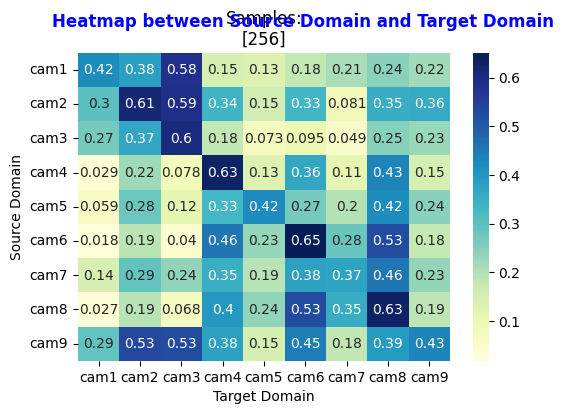

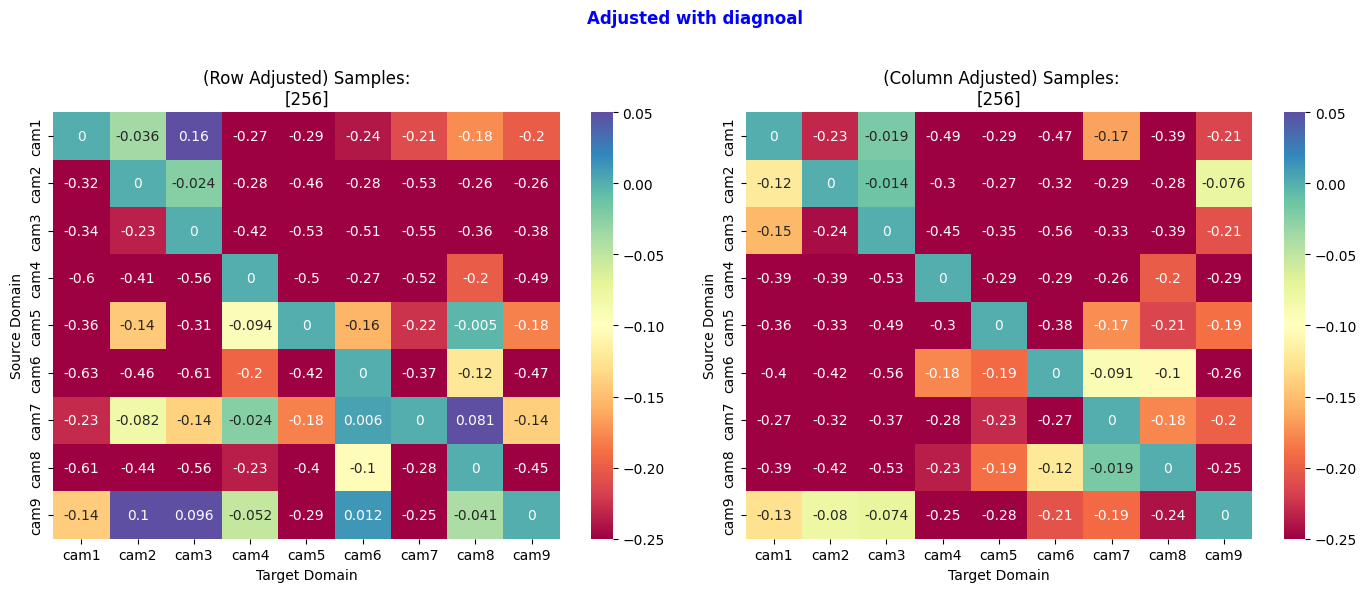

In [83]:
# Test the function with different samples
#samples_list = [[16,32,48,64,80,96,128,216,256]]

samples_list = [[256]]
for samples in samples_list:
    clustering_df,_,_ = filter_df(df_stream,
                               strategies=['thresholded-top-confidence-max'],
                               dom_periods=restricted_dom_periods,
                               samples=samples)
    pivot_df, pivot_df_diag_row_adjusted, pivot_df_diag_column_adjusted = plot_heatmap(clustering_df,
                                                                                       samples)
#display(yolov8n_df[['target_domain','mAP50-95']])

The analysis of the HEATMAP shows

1. The diagonal shows some videos are difficult for the models to have good performances on. 
2. The adjusted diagnoal for rows shows that the model can sometimes better performing on other target domains 
3. The adjusted shows that depending on the source_domain the model has been trained on, it will always be underperforming on other target_domains. The under-performance will be more or less suggesting that a model trained on a cam 1 can distill knowledge on cam3. 


<h2> <font color="blue"> 2.2 Hiearchichal Clustering </font><h2>


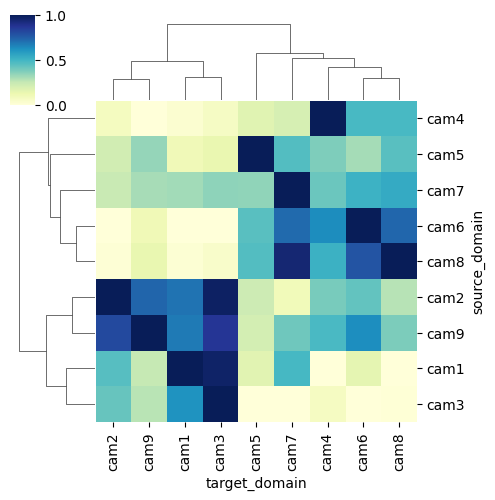

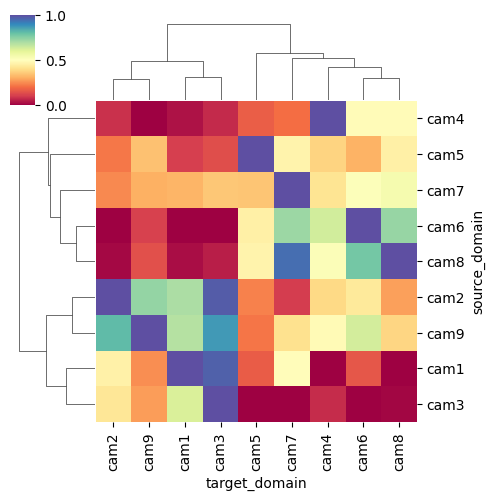

In [84]:
# Create the clustermap plots
grid = sns.clustermap(pivot_df, cmap='YlGnBu', standard_scale=1, figsize=(5, 5))
grid_column_adjusted = sns.clustermap(pivot_df_diag_column_adjusted, 
                                      cmap='Spectral', 
                                      standard_scale=1, 
                                      figsize=(5, 5))

<h2> <font color="blue"> 2.3 Definition of the clustering </font><h2>

In [58]:
from scipy.cluster.hierarchy import fcluster
import numpy as np

def calculate_clusters(linkage_matrix, min_threshold, max_threshold, step):
    first_occurrences = {}
    seen_clusters = set()

    for threshold in np.arange(min_threshold, max_threshold, step):
        clusters = fcluster(linkage_matrix, threshold, criterion='distance')
        num_clusters = len(np.unique(clusters))
        
        if num_clusters not in seen_clusters:
            seen_clusters.add(num_clusters)
            first_occurrences[num_clusters] = {'threshold': threshold, 'clusters': []}
            
            for cluster_num in range(1, num_clusters + 1):
                indices = np.where(clusters == cluster_num)[0] + 1 # Increment indices by 1
                first_occurrences[num_clusters]['clusters'].append(indices)
    return first_occurrences

# Get the linkage matrix for the rows
row_linkage = grid.dendrogram_row.linkage
row_clusters = calculate_clusters(row_linkage, 0.5, 1.5, 0.05)

row_linkage_adjusted = grid_column_adjusted.dendrogram_row.linkage
row_clusters_adjusted = calculate_clusters(row_linkage_adjusted, 0.5, 1.5, 0.05)

# Function to format the threshold with two decimal places
def format_threshold(threshold):
    return "{:.2f}".format(threshold)

# Set the maximum number of num_clusters to display
max_num_clusters_to_display = 4

# Get the sorted unique num_clusters
sorted_num_clusters = sorted(set(row_clusters.keys()).union(set(row_clusters_adjusted.keys())))

# Limit the number of num_clusters to display
num_clusters_to_display = sorted_num_clusters[:max_num_clusters_to_display]

# Iterate through clusters and print results side by side for the selected num_clusters
for num_clusters in num_clusters_to_display:
    # Grid 1
    if num_clusters in row_clusters:
        print('Grid 1:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Grid 1: No clusters found at this threshold.')
        
    print('\t\t\t')

    # Grid 2
    if num_clusters in row_clusters_adjusted:
        print('Adjusted Grid:')
        print(f'{num_clusters} clusters at threshold {format_threshold(row_clusters_adjusted[num_clusters]["threshold"])}:')
        for i, indices in enumerate(row_clusters_adjusted[num_clusters]['clusters']):
            print(f'Cluster {i+1}: {indices}')
    else:
        print('Adjusted Grid: No clusters found at this threshold.')
    
    print('\n')


Grid 1:
2 clusters at threshold 1.15:
Cluster 1: [4 5 6 7 8]
Cluster 2: [1 2 3 9]
			
Adjusted Grid:
2 clusters at threshold 1.15:
Cluster 1: [4 5 6 7 8]
Cluster 2: [1 2 3 9]


Grid 1:
3 clusters at threshold 1.10:
Cluster 1: [4 5 6 7 8]
Cluster 2: [2 9]
Cluster 3: [1 3]
			
Adjusted Grid:
3 clusters at threshold 1.10:
Cluster 1: [4 5 6 7 8]
Cluster 2: [2 9]
Cluster 3: [1 3]


Grid 1:
4 clusters at threshold 1.05:
Cluster 1: [5 6 7 8]
Cluster 2: [4]
Cluster 3: [2 9]
Cluster 4: [1 3]
			
Adjusted Grid:
4 clusters at threshold 1.05:
Cluster 1: [5 6 7 8]
Cluster 2: [4]
Cluster 3: [2 9]
Cluster 4: [1 3]


Grid 1:
5 clusters at threshold 0.85:
Cluster 1: [6 7 8]
Cluster 2: [5]
Cluster 3: [4]
Cluster 4: [2 9]
Cluster 5: [1 3]
			
Adjusted Grid:
5 clusters at threshold 0.85:
Cluster 1: [6 7 8]
Cluster 2: [5]
Cluster 3: [4]
Cluster 4: [2 9]
Cluster 5: [1 3]




The application of different thresholds leads to a varying number of clusters as follows:

- **Threshold = 1.2:**   
  With this threshold, we get **2 clusters**:
    - **Cluster 1:** Contains cameras 1, 2, 3, and 9
    - **Cluster 2:** Contains cameras 4, 5, 6, 7, and 8

- **Threshold = 1.05:**  
  With this threshold, we get **3 clusters**:
    - **Cluster 1:** Contains cameras 4, 5, 6, 7, and 8
    - **Cluster 2:** Contains cameras 1 and 3
    - **Cluster 3:** Contains cameras 2 and 9

- **Threshold = 1:**   
  With this threshold, we get **4 clusters**:
    - **Cluster 1:** Contains cameras 4, 6, 7, and 8
    - **Cluster 2:** Contains cameras 1 and 3
    - **Cluster 3:** Contains cameras 2 and 9
    - **Cluster 4:** Contains camera 5

- **Threshold < 1:**  
  With a threshold less than 1, we get **5 clusters**:
    - **Cluster 1:** Contains cameras 4, 6, and 8
    - **Cluster 2:** Contains camera 7
    - **Cluster 3:** Contains cameras 2 and 9
    - **Cluster 4:** Contains camera 5
    - **Cluster 5:** Contains cameras 1 and 9

The choice of the threshold should be based on domain knowledge and the specific use case.


1. The analysis shows that both adjusted leads to the same conclusion
2. The definition of the clustering will help us analysing whether with-respect to clustering and training one or several model. 



<h1> <font color="blue"> 3. Clustering Performance Analysis </font> </h1>

In [85]:
def assign_cluster(cam,clusters):
    inclusters=[]
    outclusters=[]
    for cluster in clusters:
        a,b,c,d=process_domains_periods(cluster['source_domain'], cluster['source_period'], restricted_dom_periods)
        if(cam in b):
            inclusters.append(cluster)
        else:
            outclusters.append(cluster)
            
    return inclusters,outclusters  

def generate_cameras_pairs(input_string):
    # Find the index of the '-week'
    week_index = input_string.index('-week')

    # Get the cameras and weeks as lists of characters
    cameras = input_string[:week_index].split('o')
    weeks = input_string[week_index+5:].split('o')

    # Add the 'cam' prefix to each camera if not already there
    cameras = ['cam' + cam if not cam.startswith('cam') else cam for cam in cameras]
    weeks = ['week' + week for week in weeks]

    # Check that the number of cameras is equal to the number of weeks
    if len(cameras) != len(weeks):
        raise ValueError("The number of cameras must be equal to the number of weeks")

    # Generate the output
    output = list(zip(cameras, weeks))
    
    return output


def process_domains_periods(source_domain, source_period, eligible_clustering_domain_periods):
    joined_string = source_domain + "-" + source_period
    domains_periods = generate_cameras_pairs(joined_string)
    included_domains = [pair[0] for pair in domains_periods]
    excluded_domains_periods = [pair for pair in eligible_clustering_domain_periods if pair not in domains_periods]
    excluded_domains = [pair[0] for pair in excluded_domains_periods]
    return domains_periods, included_domains,excluded_domains_periods,excluded_domains


def add_row_to_results(df, data):
    new_row = pd.DataFrame([data])
    return pd.concat([df, new_row], ignore_index=True)

def test_strategies(number_cluster,
                    cluster_content, 
                    selected_sample_sizes,
                    selected_strategy,
                    selected_source_domain_multi,
                    selected_source_period_multi,
                    restricted_eligible_clustering_df,
                    df_multistream,
                    excluded_domains_df,
                    included_target_domains,
                    excluded_target_domains):
    
    results = pd.DataFrame()
    
    for sample_size in selected_sample_sizes:
        for strategy in selected_strategy:
            
            #IN CLUSTER COMPUTATION 
            one_strategy_one_sample_df, mean_self,_ = filter_df(restricted_eligible_clustering_df, 
                                                                 strategies=[strategy], 
                                                                 samples=[sample_size])
            
            filtered_df_multistream, mean_multi,_ = filter_df(df_multistream, 
                                                               strategies=[strategy], 
                                                               samples= [sample_size], 
                                                               source_periods=[selected_source_period_multi], 
                                                               source_domains=[selected_source_domain_multi], 
                                                               excluded_domains=[excluded_target_domains])
            
            stats_in= perform_statistical_tests(one_strategy_one_sample_df, filtered_df_multistream,'single-stream','multi-stream')
            
            #OUT CLUSTER COMPUTATION
            one_strategy_one_sample_df_out,mean_self_out,c = filter_df(excluded_domains_df,
                                                                         strategies = [strategy], 
                                                                         samples=[sample_size])
            
            filtered_df_multistream_out,mean_multi_out,c = filter_df(df_multistream,
                                                                       strategies=[strategy], 
                                                                       samples=[sample_size], 
                                                                       source_periods=[selected_source_period_multi], 
                                                                       source_domains=[selected_source_domain_multi], 
                                                                       excluded_domains=included_target_domains)

            stats_out = perform_statistical_tests(one_strategy_one_sample_df_out, 
                                                  filtered_df_multistream_out,
                                                  'single-stream',
                                                  'multi-stream','excl')
            
            data = {'samples': sample_size, 
                    'strategy': strategy, 
                    'mean self': mean_self,
                    'mean multi': mean_multi,
                    'cluster numbers': number_cluster,
                    'cameras': cluster_content,
                    **stats_in,
                    'mean self_out': mean_self,
                    'mean multi_out': mean_multi_out,
                    **stats_out}
            results = add_row_to_results(results, data)
        
    return results



def analyze_performance(number_cluster, 
                        selected_strategy,
                        sample_sizes,
                        source_domain, 
                        source_period,
                        eligible_clustering_domain_periods,
                        df_stream,
                        df_multistream):
    
    sixteen_multiple_sample_size = [16,32,48,64,80,96,128,216,256]
    
    domain_periods, included_domains, excluded_domains_periods, excluded_domains = process_domains_periods(source_domain,source_period, eligible_clustering_domain_periods)
    
    included_domains_df, _ , _ = filter_df(df_stream,
                                   same_domain=True,
                                   samples=sixteen_multiple_sample_size,
                                   dom_periods=domain_periods)
    
    excluded_domains_df, _ , _ = filter_df(df_stream,
                                   same_domain=True,
                                   samples=sixteen_multiple_sample_size,
                                   dom_periods=excluded_domains_periods)
    
    cluster_cameras = ", ".join([cam for cam, _ in domain_periods])
    
    #print('Number of records:', len(restricted_eligible_clustering_df))
    #print('Mean mAP50-95:', restricted_eligible_clustering_df['mAP50-95'].mean())

    results_df = test_strategies(number_cluster,
                                 cluster_cameras,
                                 sample_sizes,
                                 selected_strategy,
                                 source_domain,
                                 source_period,
                                 included_domains_df,
                                 df_multistream,
                                 excluded_domains_df,
                                 included_domains,
                                 excluded_domains)
    
    return results_df

In [66]:
selected_strategy =['n-first','uniform-random-0','thresholded-top-confidence-max']
selected_sample_sizes= [96,216]

# Create an empty DataFrame for final results
final_results_df = pd.DataFrame()

# Define clusters
clusters = [
    {
        'number': 1,
        'source_domain': 'cam1o2o3o4o5o6o7o8o9',
        'source_period': 'week1o1o5o2o3o4o4o3o1'
    },
    {
        'number': 2,
        'source_domain': 'cam1o2o3o9',
        'source_period': 'week1o1o5o1'
    },
    {
        'number': 2,
        'source_domain': 'cam4o5o6o7o8',
        'source_period': 'week2o3o4o4o3'
    },
    {
        'number': 3,
        'source_domain': 'cam4o5o6o7o8',
        'source_period': 'week2o3o4o4o3'
    },
    {
        'number': 3,
        'source_domain': 'cam1o3',
        'source_period': 'week1o5'
    },
    
    {
      'number': 3,
       'source_domain': 'cam2o9',
        'source_period': 'week1o1'
    },
]

for cluster in clusters:
    results_df = analyze_performance(cluster["number"], 
                                     selected_strategy, 
                                     selected_sample_sizes,  
                                     cluster["source_domain"], 
                                     cluster["source_period"],
                                     restricted_dom_periods,
                                     df_stream,
                                     df_multistream)
    final_results_df = pd.concat([final_results_df, results_df])


display(final_results_df)


,samples,strategy,mean self,mean multi,cluster numbers,cameras,t-statistic,p-value,T-test result,shapiro-wilk single-stream,...,p-value_excl,T-test result_excl,shapiro-wilk single-stream_excl,shapiro-wilk single-stream result_excl,shapiro-wilk multi-stream_excl,shapiro-wilk multi-stream result_excl,levene_excl,levene result_excl,mann-whitney u_excl,mann-whitney u result_excl
0,96,n-first,0.352,0.413,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",-0.902,0.380,Means statistically undifferent,0.461,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
1,96,uniform-random-0,0.468,0.372,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",1.588,0.132,Means statistically undifferent,0.280,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
2,96,thresholded-top-confidence-max,0.502,0.480,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.379,0.709,Means statistically undifferent,0.007,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
3,216,n-first,0.383,0.423,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",-0.605,0.554,Means statistically undifferent,0.026,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
4,216,uniform-random-0,0.472,0.425,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.638,0.533,Means statistically undifferent,0.003,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
5,216,thresholded-top-confidence-max,0.529,0.488,1,"cam1, cam2, cam3, cam4, cam5, cam6, cam7, cam8...",0.682,0.505,Means statistically undifferent,0.013,...,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable,NaN,Not testable
0,96,n-first,0.352,0.332,2,"cam1, cam2, cam3, cam9",0.262,0.797,Means statistically undifferent,0.461,...,0.248,Means statistically undifferent,0.461,Sample looks Gaussian (fail to reject H0),0.110,Sample looks Gaussian (fail to reject H0),0.581,Variances look equal (fail to reject H0),0.147,Same distribution (fail to reject H0)
1,96,uniform-random-0,0.468,0.282,2,"cam1, cam2, cam3, cam9",3.181,0.006,Means statistically different (reject H0),0.280,...,0.001,Means statistically different (reject H0),0.280,Sample looks Gaussian (fail to reject H0),0.884,Sample looks Gaussian (fail to reject H0),0.439,Variances look equal (fail to reject H0),0.002,Different distribution (reject H0)
2,96,thresholded-top-confidence-max,0.502,0.399,2,"cam1, cam2, cam3, cam9",1.786,0.093,Means statistically undifferent,0.007,...,0.021,Means statistically different (reject H0),0.007,Sample does not look Gaussian (reject H0),0.128,Sample looks Gaussian (fail to reject H0),0.854,Variances look equal (fail to reject H0),0.147,Same distribution (fail to reject H0)
3,216,n-first,0.383,0.330,2,"cam1, cam2, cam3, cam9",0.697,0.496,Means statistically undifferent,0.026,...,0.069,Means statistically undifferent,0.026,Sample does not look Gaussian (reject H0),0.600,Sample looks Gaussian (fail to reject H0),0.820,Variances look equal (fail to reject H0),0.019,Different distribution (reject H0)


<h2> <font color="blue"> 3.1 Performance analysis of 1 cluster </font> </h2>





<h2> <font color="blue"> 3.2 Performance analysis of 2 cluster - CLUSTER of CAMERAS 1,2,3 and 9 </font> </h2>

In [67]:
# Define the column names to display
display_columns = ['Number Cluster', 'Cluster Content', 'Mean Single Stream', 'Mean Multi', 'T-Test result']


def highlight_rows(s):
    styles = [''] * len(s)
    for i, (mean_multi, mean_single) in enumerate(zip(s['Mean Multi'], s['Mean Single Stream'])):
        if mean_multi > mean_single:
            styles[i] = 'color: red'
    return styles

# Now, loop over unique strategies and sample sizes
for strategy in selected_strategy:
    for sample in selected_sample_sizes:
        strategy_sample_df = final_results_df[(final_results_df['strategy'] == strategy) & (final_results_df['Sample Size'] == sample)]
        
        # If DataFrame is not empty, display it
        if not strategy_sample_df.empty:
            # Print title in blue with HTML tags
            display(HTML(f"<h2 style='color:blue;'><b>Strategy: {strategy}, Sample Size: {sample}</b></h2>"))
            
            # Note: use pd.set_option to format all floats to 3 decimal places
            with pd.option_context('display.float_format', '{:.3f}'.format): 
                df_to_display = strategy_sample_df[display_columns].reset_index(drop=True)
                
                # Apply row highlighter
                df_to_display.style.apply(highlight_rows, axis=1)
                
                # Display the DataFrame
                display(df_to_display)
        else:
            print(f"No data available for strategy {strategy} and sample size {sample}")


KeyError: 'Sample Size'

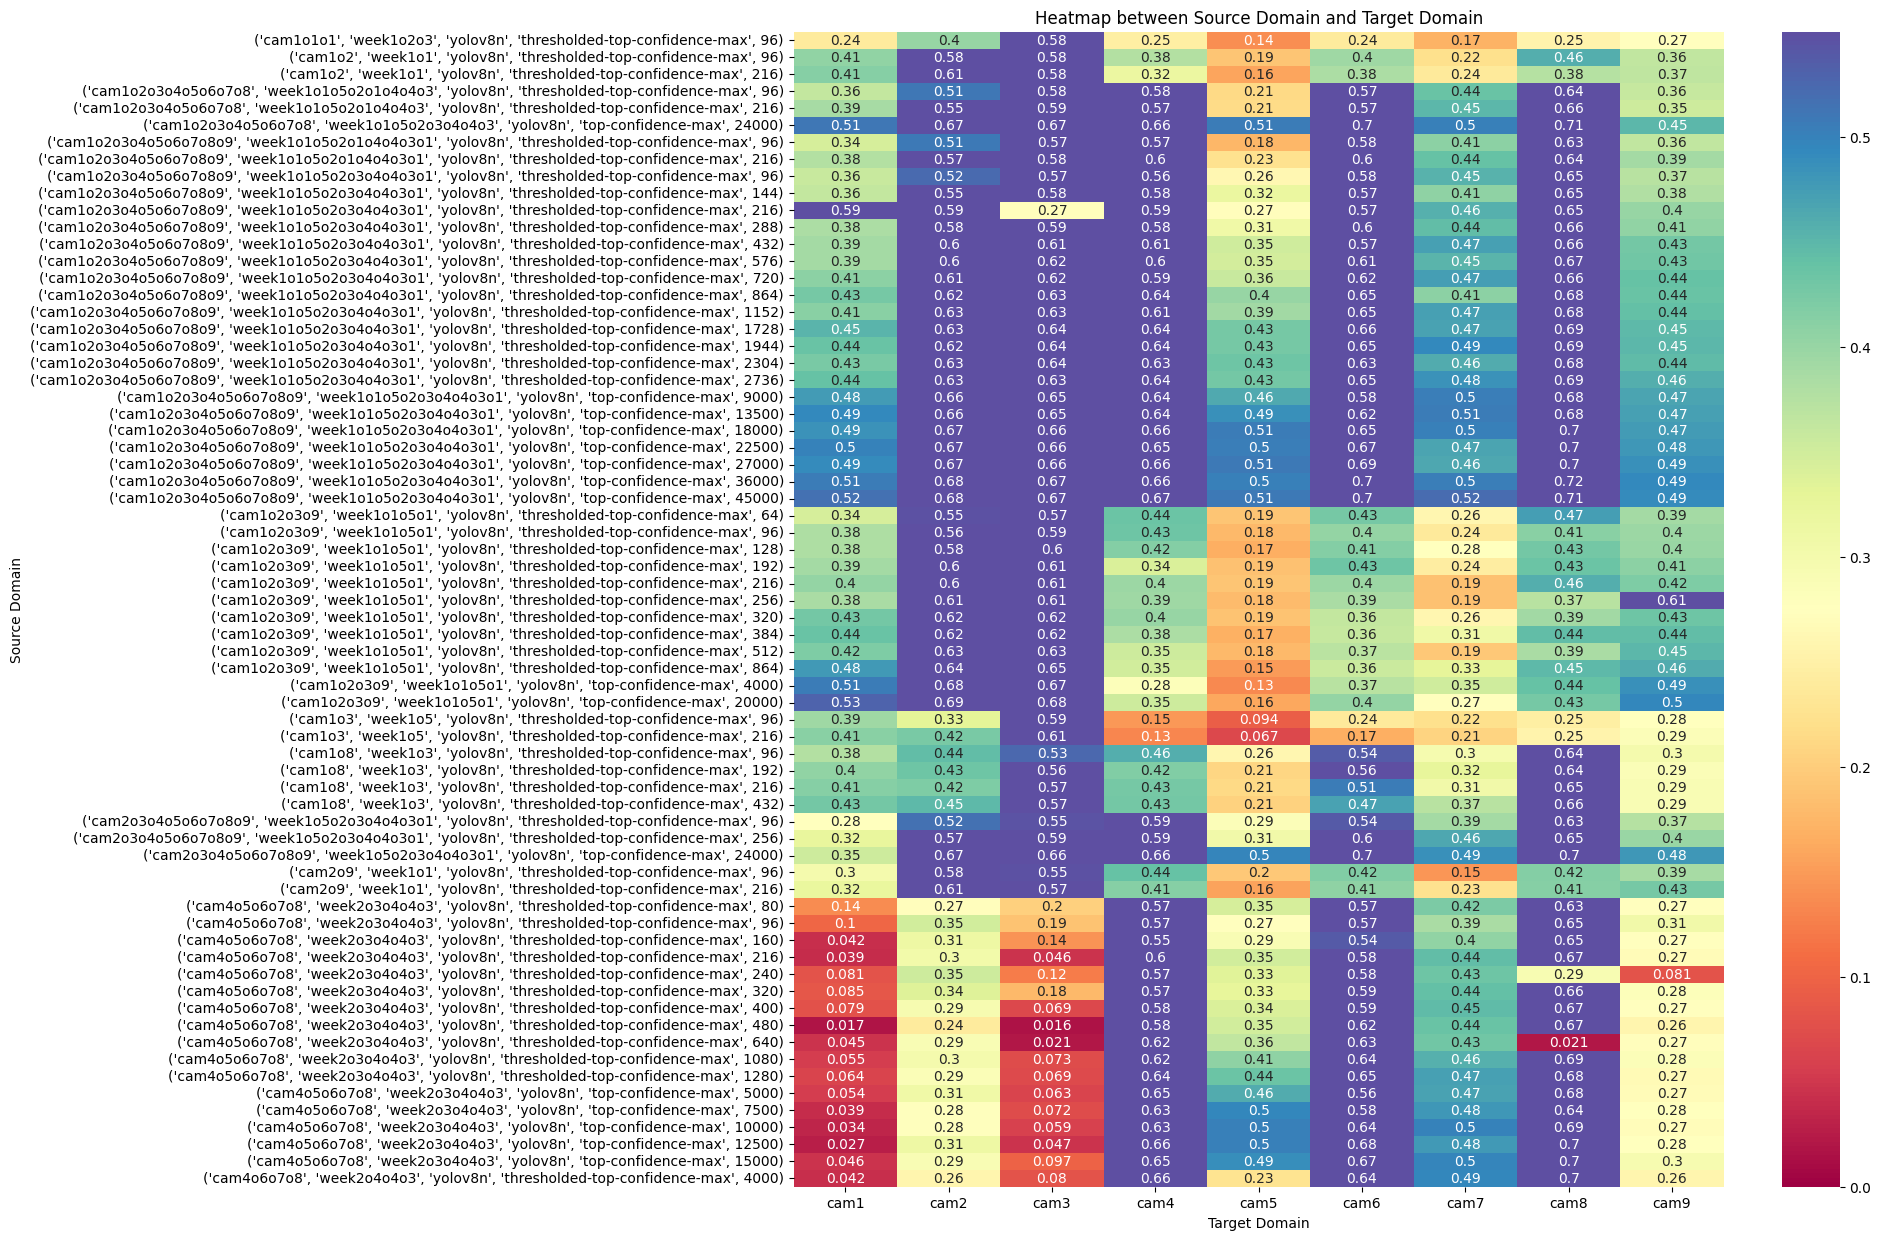

In [64]:
df_multistream['source_combo'] = list(zip(df_multistream['source_domain'], df_multistream['source_period'], df_multistream['student'], df_multistream['strategy'], df_multistream['samples']))

source_domaines=['cam1o2','cam1o3']
student=['yolov8n']
selected_strategies=['thresholded-top-confidence-max','top-confidence-max']
eligible_df_multistream = df_multistream[df_multistream['strategy'].isin(selected_strategies)&
                                         df_multistream['student'].isin(student)]
grouped_df = eligible_df_multistream.groupby(['source_combo', 'target_domain'], as_index=False)['mAP50-95'].mean()

# Now pivot the grouped DataFrame
pivot_df = grouped_df.pivot(index='source_combo', columns='target_domain', values='mAP50-95')

# Plotting the first heatmap (without any adjustments)
plt.figure(figsize=(15,15)) 
sns.heatmap(pivot_df, annot=True, vmin=0, vmax=0.55, cmap='Spectral')
plt.title('Heatmap between Source Domain and Target Domain')
plt.xlabel('Target Domain')
plt.ylabel('Source Domain')
plt.show()

<h2> <font color="blue"> 3.4. Finite Bandwith - storage and time constraint - limited labelling equivalent - Decentralized setting n_total= n_samples Single camera analysis - fixed total # of samples ultra-fast deployment</font> </h2>

In [ ]:
def generate_df(cam_week_tuples, strategy, samples, df, df_multistream):
    # Create an empty DataFrame
    result_df = pd.DataFrame()
    
    # Loop over each cam, week tuple
    for cam_week_tuple in cam_week_tuples:
        # Unpack the tuple into cam and week variables
        data={}
        cam, week = cam_week_tuple
        data["cam"]=cam
        inclusters,outclusters = assign_cluster(cam, clusters)
        # Loop over each sample
        for sample in samples:
            data["samples"]=sample
            
            a,mean_cam_self,_=filter_df(df,
                                        same_domain=True,
                                        strategies=[strategy],
                                        source_domains=[cam],
                                        source_periods=[week],
                                        samples=[sample])
            data["self"]=mean_cam_self
            for cls in inclusters:
                _,cluster_mean,_=filter_df(df_multistream, 
                                               strategies=[strategy], 
                                               source_domains=[cls['source_domain']], 
                                               source_periods=[cls['source_period']], 
                                               samples=[sample],
                                               target_domain=[cam])
                data[f"cls_{cls['number']}"] = cluster_mean
            for cls in outclusters:
                _,anticluster_mean,_= filter_df(df_multistream, 
                                             strategies=[strategy], 
                                             source_domains=[cls['source_domain']],
                                             source_periods=[cls['source_period']], 
                                             samples=[sample],
                                             target_domain=[cam])
                
                data[f"anticls_{cls['number']}"]=anticluster_mean
                # Append the results to the DataFrame
            result_df = pd.concat([result_df, pd.DataFrame([data])], ignore_index=True)
            
    return result_df

cam_week_tuples = [('cam1', 'week1')]   # replace with your tuples
samples = [96,216]   # replace with your samples
df_cluster_analysis = generate_df(restricted_dom_periods, 
                 'thresholded-top-confidence-max', 
                 samples, 
                 df_stream, 
                 df_multistream)
print(df)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
grouped_df = df.groupby(['samples']).mean(numeric_only=True)
print(grouped_df)

<h2> <font color="blue"> 3.5. Finite Bandwith - Storage and Time Constraint - Limited labelling equivalent - Centralized setting to fixed # of samples per camera - total samples = n_cameras X n_samples TOTAL ANNOTATION BUDGET  </font> </h2>

In [ ]:
def generate_df(cam_week_tuples, strategy, samples, df, df_multistream):
    # Create an empty DataFrame
    result_df = pd.DataFrame()
    
    # Loop over each cam, week tuple
    for cam_week_tuple in cam_week_tuples:
        # Unpack the tuple into cam and week variables
        data={}
        cam, week = cam_week_tuple
        data["cam"]=cam
        inclusters,outclusters = assign_cluster(cam, clusters)
        # Loop over each sample
        for sample in samples:
            data["smpls self"]=sample
            a,mean_cam_self,_=filter_df(df,
                                        same_domain=True,
                                        strategies=[strategy],
                                        source_domains=[cam],
                                        source_periods=[week],
                                        samples=[sample])
            data["self"]=mean_cam_self
            for cls in inclusters:
                in_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], restricted_dom_periods)
                number_of_samples = len(in_cameras)*sample
                _,cluster_mean,_=filter_df(df_multistream, 
                                           strategies=[strategy], 
                                           source_domains=[cls['source_domain']], 
                                           source_periods=[cls['source_period']], 
                                           samples=[number_of_samples],
                                           target_domain=[cam])
                
                data[f"smpls cls_{cls['number']}"]=number_of_samples
                data[f"cam cls_{cls['number']}"]=b
                data[f"mean cls_{cls['number']}"] = cluster_mean
                
            for cls in outclusters:
                anti_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], restricted_dom_periods)
                number_of_samples = len(anti_cameras)*sample
                data[f"anticam cls_{cls['number']}"]=b
                data[f"smpls anti_cls{cls['number']}"]=number_of_samples
                _,anticluster_mean,_= filter_df(df_multistream, 
                                                strategies=[strategy], 
                                                source_domains=[cls['source_domain']],
                                                source_periods=[cls['source_period']], 
                                                samples=[number_of_samples],
                                                target_domain=[cam])
                data[f"mean anticls_{cls['number']}"]=anticluster_mean
                # Append the results to the DataFrame
            result_df = pd.concat([result_df, pd.DataFrame([data])], ignore_index=True)
        
    return result_df


samples = [16,32,96,216]   # replace with your samples
df_cluster2 = generate_df(scal_dom_periods, 'thresholded-top-confidence-max', samples, df_stream, df_multistream)
display(df_cluster2)
grouped_df = df_cluster2.groupby(['smpls self']).mean(numeric_only=True)

target_domain  mAP50-95  smpls cls_1  cam cls_1  \
strategy samples                                                     
1-models 144.000               9         9            9          9   
         288.000               9         9            9          9   
         576.000               9         9            9          9   
         720.000               9         9            9          9   
         864.000               9         9            9          9   
         1944.000              9         9            9          9   
         2304.000              9         9            9          9   
2-models 144.000               9         9            0          0   
         288.000               9         9            0          0   
         576.000               9         9            0          0   
         720.000               9         9            0          0   
         864.000               9         9            0          0   
         1944.000              9         9            0          0   
         2304.000              9         9            0          0   
3-models 144.000               9         9            0          0   
         288.000               9         9            0          0   
         576.000               9         9            0          0   
         720.000               9         9            0          0   
         864.000               9         9            0          0   
         1944.000              9         9            0          0   
         2304.000              9         9            0          0   
9-models 144.000               9         9            0          0   
         288.000               9         9            0          0   
         576.000               9         9            0          0   
         720.000               9         9            0          0   
         864.000               9         9            0          0   
         1944.000              9         9            0          0   
         2304.000              9         9            0          0   

                   smpls cls_2  cam cls_2  smpls cls_3  cam cls_3  
strategy samples                                                   
1-models 144.000             0          0            0          0  
         288.000             0          0            0          0  
         576.000             0          0            0          0  
         720.000             0          0            0          0  
         864.000             0          0            0          0  
         1944.000            0          0            0          0  
         2304.000            0          0            0          0  
2-models 144.000             9          9            0          0  
         288.000             9          9            0          0  
         576.000             9          9            0          0  
         720.000             9          9            0          0  
         864.000             9          9            0          0  
         1944.000            9          9            0          0  
         2304.000            9          9            0          0  
3-models 144.000             0          0            9          9  
         288.000             0          0            9          9  
         576.000             0          0            9          9  
         720.000             0          0            9          9  
         864.000             0          0            9          9  
         1944.000            0          0            9          9  
         2304.000            0          0            9          9  
9-models 144.000             0          0            0          0  
         288.000             0          0            0          0  
         576.000             0          0            0          0  
         720.000             0          0            0          0  
         864.000             0          0            0          0  
         1944.

mAP50-95  smpls cls_1  smpls cls_2  smpls cls_3
strategy samples                                                  
1-models 144.000      0.489      144.000          NaN          NaN
         288.000      0.505      288.000          NaN          NaN
         576.000      0.525      576.000          NaN          NaN
         720.000      0.531      720.000          NaN          NaN
         864.000      0.545      864.000          NaN          NaN
         1944.000     0.559     1944.000          NaN          NaN
         2304.000     0.553     2304.000          NaN          NaN
2-models 144.000      0.488          NaN       72.889          NaN
         288.000      0.489          NaN      145.778          NaN
         576.000      0.534          NaN      291.556          NaN
         720.000      0.526          NaN      364.444          NaN
         864.000      0.530          NaN      437.333          NaN
         1944.000     0.561          NaN      984.000          NaN
         2304.000     0.564          NaN     1166.222          NaN
3-models 144.000      0.482          NaN          NaN       58.667
         288.000      0.485          NaN          NaN      117.333
         576.000      0.509          NaN          NaN      234.667
         720.000      0.517          NaN          NaN      293.333
         864.000      0.521          NaN          NaN      352.000
         1944.000     0.550          NaN          NaN      792.000
         2304.000     0.558          NaN          NaN      938.667
9-models 144.000      0.428          NaN          NaN          NaN
         288.000      0.485          NaN          NaN          NaN
         576.000      0.506          NaN          NaN          NaN
         720.000      0.496          NaN          NaN          NaN
         864.000      0.502          NaN          NaN          NaN
         1944.000     0.529          NaN          NaN          NaN
         2304.000     0.531          NaN          NaN          NaN

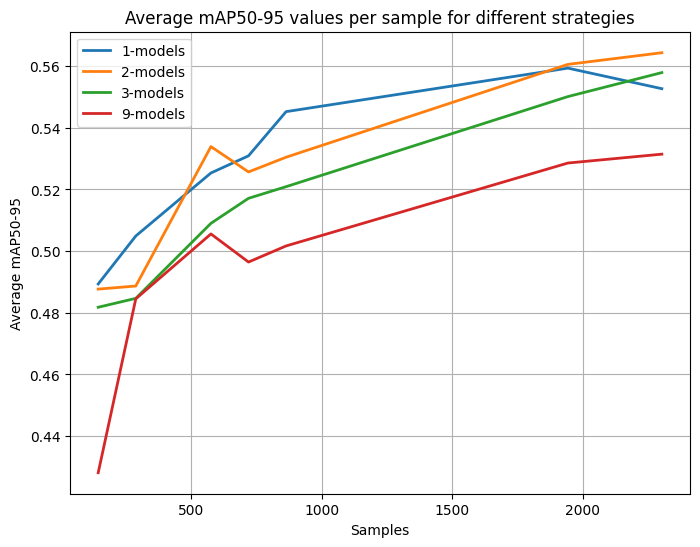

In [94]:

def total_df(cam_week_tuples, strategy, samples, df, df_multistream):
    # Create an empty DataFrame
    result_df = pd.DataFrame()
    
    # Loop over each cam, week tuple
    for cam_week_tuple in cam_week_tuples:
        # Unpack the tuple into cam and week variables
        data1={}
        
        cam, week = cam_week_tuple
        data1["target_domain"]=cam
        inclusters,outclusters = assign_cluster(cam, clusters)
        # Loop over each sample
        for sample in samples:
            data1["samples"]=sample*9
            a,mean_cam_self,_=filter_df(df,
                                        same_domain=True,
                                        strategies=[strategy],
                                        source_domains=[cam],
                                        source_periods=[week],
                                        samples=[sample],
                                        students=['yolov8n'])
            data1["strategy"]= '9-models'
            data1["mAP50-95"]=mean_cam_self
            result_df = pd.concat([result_df, pd.DataFrame([data1])], ignore_index=True)

            for cls in inclusters:
                data2={}
                data2["target_domain"]=cam
                in_cameras, b, c, d= process_domains_periods(cls['source_domain'], cls['source_period'], restricted_dom_periods)
                number_of_samples = len(in_cameras)*sample
                _,cluster_mean,_=filter_df(df_multistream, 
                                           strategies=[strategy], 
                                           source_domains=[cls['source_domain']], 
                                           source_periods=[cls['source_period']], 
                                           samples=[number_of_samples],
                                           target_domain=[cam],
                                           students=['yolov8n'])
                data2[f"samples"]=number_of_samples*9/len(in_cameras)
                data2[f"strategy"]=f"{cls['number']}-models"
                data2["mAP50-95"] = cluster_mean
                data2[f"smpls cls_{cls['number']}"]=number_of_samples
                data2[f"cam cls_{cls['number']}"]=b
                
                result_df = pd.concat([result_df, pd.DataFrame([data2])], ignore_index=True)
        
    return result_df


samples = [16,32,64,80,96,216,256]   # replace with your samples
df_cluster3 = total_df(restricted_dom_periods, 'thresholded-top-confidence-max', samples, df_stream, df_multistream)
#display(df_cluster3)
display(df_cluster3.groupby(['strategy', 'samples']).count())
grouped_df = df_cluster3.groupby(['strategy', 'samples']).mean(numeric_only=True)
display(grouped_df)

benchmark_strategies_plot(df_cluster3)


In this scenario we consider a setting where the local transmission is limited forcing to select a limited sample 
The analysis shows that if you have access to multiple cameras and that the labelling is not an issue, there is no interest to specialized on a single domain. WE HAVE TO PLOT A GRAPH with TOTAL BUDGET 1 model per camera vs 1 model for all the cameras. TOTAL BUDGET. It should display:

We should do the following run : 
[144, 288, 432, 576, 720, 864, 1152, 1944, 2304] 1-cluster
[                                              ] 2 models

Of course this works better but one should be careful that it's not the effect of the strategy that is not maximizing. Indeed, one can easily argue that 

Clustering conclusion : 

1. One model from all the source_domain is better than sub-domain. Clustering does not provide a competitive advantage. 

2. We also lose in generalizability without performance compensentation as clustering. 

<h1> <font color="blue"> 4. POOL-BASED AND SAMPLE BASED SCENARIOS </font><h1>

<h2> <font color="blue"> 4.1 ANALYSIS OF THE STRATEGIES </font><h2>

In [ ]:
pool_strategies = ['n-first', 'least-confidence-max', 'top-confidence-max']
pool_multiple_sample_size = [250, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
MODELS_TO_PLOT = ['yolov8n', 'yolov8m', 'yolov8x6']
df_poolbasedallsamples = generate_plot(same_domain_df_poolbased, 
                                     pool_strategies,
                                     pool_multiple_sample_size,
                                     scal_dom_periods, 
                                     df_models,
                                     MODELS_TO_PLOT,
                                    'random')

In [ ]:
sample = 45000
strategy='top-confidence-max'
my_df = df_multistream
strat_df= filter_data(strategy, sample, my_df,source_domain='cam1e2e3e4e5e6e7e8e9')
#display(strat_df)
yolov8n_df= filter_data('yolov8n',0,df_models)
yolov8x6_df= filter_data('yolov8x6',0,df_models)

mean_strat = strat_df['mAP50-95'].mean()
mean_yolov8n= yolov8n_df['mAP50-95'].mean()
mean_yolov8x6= yolov8x6_df['mAP50-95'].mean()

stats_data = perform_statistical_tests(strat_df, yolov8x6_df,'strategy','yolov8x6')

data = {'samples': sample, 
        'strategy': strategy, 
        'mean': mean_strat,
        'mean_yolov8n': mean_yolov8n,
        **stats_data}

formatted_data = {k: (f"{v:.3f}" if isinstance(v, (int, float)) else v) for k, v in data.items()}
display(formatted_data)

The analysis shows a significant improvement by generating a model based on 5000 images from 9 cameras.

Below that the improvement is not statistically significant. 

<h1> <font color="blue"> 5. TWO -iterations fine-tuning </font><h1>